In [1]:
#initialnize spark
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("ml").getOrCreate()

from pyspark.sql import SQLContext
sqlContext = SQLContext(spark)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#read datasets
Names=["ad_info","category","combined_stream","location","search_click","search_info","user_info"]
df_ad_info,df_category,df_combined_stream,df_location,df_search_click,df_search_info,df_user_info=[spark.read.format("csv") \
                .option("header", "true") \
                .option("delimiter", "\t") \
                .option('inferSchema', 'true') \
                .load((f"s3://bigdatateaching/project-data/{name}.txt")) for name in Names]

In [78]:
#read datasets' print schema
df_ad_info.printSchema()
df_category.printSchema()
df_combined_stream.printSchema()
df_location.printSchema()
df_search_click.printSchema()
df_search_info.printSchema()
df_user_info.printSchema()

root
 |-- AdID: integer (nullable = true)
 |-- LocationID: integer (nullable = true)
 |-- CategoryID: integer (nullable = true)
 |-- Params: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- Title: string (nullable = true)
 |-- IsContext: integer (nullable = true)

root
 |-- CategoryID: integer (nullable = true)
 |-- Level: integer (nullable = true)
 |-- ParentCategoryID: integer (nullable = true)
 |-- SubcategoryID: integer (nullable = true)

root
 |-- UserID: integer (nullable = true)
 |-- IPID: integer (nullable = true)
 |-- AdID: integer (nullable = true)
 |-- ViewDate: timestamp (nullable = true)
 |-- Source: string (nullable = true)

root
 |-- LocationID: integer (nullable = true)
 |-- Level: integer (nullable = true)
 |-- RegionID: integer (nullable = true)
 |-- CityID: integer (nullable = true)

root
 |-- SearchID: integer (nullable = true)
 |-- AdID: integer (nullable = true)
 |-- Position: integer (nullable = true)
 |-- ObjectType: integer (nullable = true)
 

In [79]:
#Remove duplicates rows

df_ad_info=df_ad_info.dropDuplicates()
df_category=df_category.dropDuplicates()
df_combined_stream=df_combined_stream.dropDuplicates()
df_location=df_location.dropDuplicates()
df_search_click=df_search_click.dropDuplicates()
df_search_info=df_search_info.dropDuplicates()
df_user_info=df_user_info.dropDuplicates()

## Search_click

In [80]:
#count search_click data
df_search_click.count()

392356948

In [4]:
#count distinct variable for different columns in search_click table dataset
for col in df_search_click.columns:
    print(col,' \t', 'with distinct values:' , df_search_click.select(col).distinct().count())

SearchID  	 with distinct values: 107863985
AdID  	 with distinct values: 22848857
Position  	 with distinct values: 5
ObjectType  	 with distinct values: 3
HistCTR  	 with distinct values: 87523
IsClick  	 with distinct values: 3


In [11]:
#count null value for different columns in search_click table dataset
for col in df_search_click.columns:
    print(col,' \t', 'with null values:' , df_search_click.filter(df_search_click[col].isNull()).count())

SearchID  	 with null values: 0
AdID  	 with null values: 0
Position  	 with null values: 0
ObjectType  	 with null values: 0
HistCTR  	 with null values: 202199213
IsClick  	 with null values: 202199213


In [3]:
#groupby ads types to plot distribution of ads types in search_click table
ObjectType_df=df_search_click.groupby("ObjectType").count().toPandas()
for i,type in enumerate(ObjectType_df['ObjectType']):
    if type==1:
        ObjectType_df['ObjectType'][i]='regular free ads'
    elif type==2:
        ObjectType_df['ObjectType'][i]='highlighted regular'   
    else:
        ObjectType_df['ObjectType'][i]='contextual ads'   

/home/hadoop/miniconda/lib/python3.7/site-packages/pyarrow/util.py:43: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead.
  warnings.warn(msg, FutureWarning)
/home/hadoop/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/hadoop/miniconda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/hadoop/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:8: 

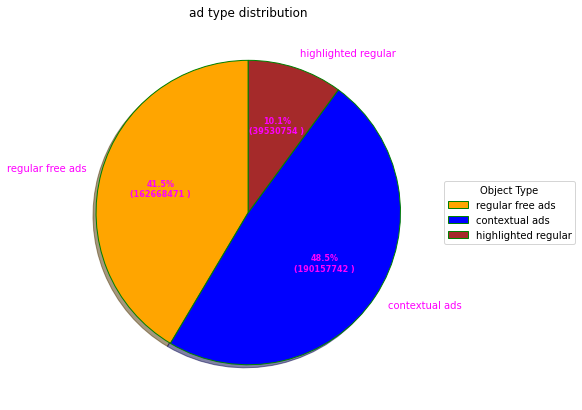

In [8]:

# Creating color parameters
colors = ( "orange", "blue", "brown")
#Wedge properties
wp = { 'linewidth' : 1, 'edgecolor' : "green" }

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d} )".format(pct, absolute)
  
# Creating plot
fig, ax = plt.subplots(figsize =(10, 7))
wedges, texts, autotexts = ax.pie(ObjectType_df['count'], 
                                  autopct = lambda pct: func(pct, ObjectType_df['count']), 
                                  labels = ObjectType_df['ObjectType'],
                                  shadow = True,
                                  colors = colors,
                                  startangle = 90,
                                  wedgeprops = wp,
                                  textprops = dict(color ="magenta"))
  
# Adding legend
ax.legend(wedges, ObjectType_df['ObjectType'],
          title ="Object Type",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))
  
plt.setp(autotexts, size = 8, weight ="bold")
ax.set_title("ad type distribution")
  
# show plot
plt.show()

In [3]:
#groupby ads types to plot distribution of position in search_click table
df=df_search_click.groupby("Position").count().toPandas()

/usr/lib/spark/python/pyspark/sql/dataframe.py:2103: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 0.8.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


<AxesSubplot:title={'center':'Ads position distribution'}, xlabel='Position'>

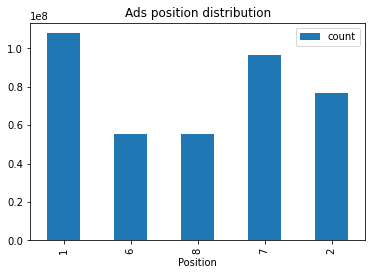

In [4]:
df.plot(kind='bar', x='Position', y='count',title='Ads position distribution')

### contextual ads exploration

In [4]:
# filter to get contextual ads dataset
df_search_click_contextual= df_search_click.filter(df_search_click["IsClick"].isNotNull()) 

In [107]:
IsClick_df=df_search_click_contextual.groupby("IsClick").count().toPandas()

for i,type in enumerate(IsClick_df['IsClick']):
    if type==1:
        IsClick_df['IsClick'][i]='Yes'
    else:
        IsClick_df['IsClick'][i]='No' 

/home/hadoop/miniconda/lib/python3.7/site-packages/pyarrow/util.py:43: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead.
  warnings.warn(msg, FutureWarning)
/home/hadoop/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/hadoop/miniconda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/hadoop/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value i

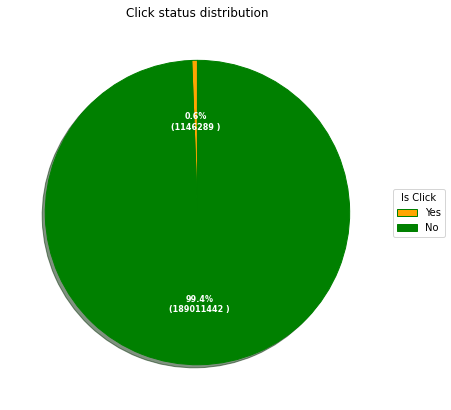

In [108]:
colors = ( "orange", "green")
# Creating plot


#Wedge properties
wp = { 'linewidth' : 1, 'edgecolor' : "green" }

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d} )".format(pct, absolute)
  
fig, ax = plt.subplots(figsize =(10, 7))
wedges, texts, autotexts = ax.pie(IsClick_df['count'], 
                                  autopct = lambda pct: func(pct, IsClick_df['count']), 
                                  labels = IsClick_df['IsClick'],
                                  shadow = True,
                                  colors = colors,
                                  startangle = 90,
                                  wedgeprops = wp,
                                  textprops = dict(color ="white"))
  
# Adding legend
ax.legend(wedges, IsClick_df['IsClick'],
          title ="Is Click",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))
  
plt.setp(autotexts, size = 8, weight ="bold")
ax.set_title("Click status distribution")
  
# show plot
plt.show()

In [5]:
import pyspark.sql.functions as F
# use groupby to count isclick and position variables
click_position_count=df_search_click_contextual.groupBy(["IsClick","Position"]).count()


In [6]:
#calculate proportions of click status among different position 
click_position_count=click_position_count.join(click_position_count.groupBy(["Position"]).sum('count'), 'Position')
click_position_count_perc=click_position_count.select('IsClick', 'Position', F.round(F.col('count')/F.col('sum(count)'), 2).alias('normalized')).toPandas()

/usr/lib/spark/python/pyspark/sql/dataframe.py:2103: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 0.8.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


In [7]:
#show pivot table for click status on different position
click_position_count_perc.pivot("Position", "IsClick", "normalized")

IsClick,0,1
Position,,
1,0.99,0.01
7,1.00,0.00


In [25]:
#Use table to show distribution of histCTR under different click status
df_search_click_contextual.select('IsClick','HistCTR').groupBy('IsClick').agg(F.min("HistCTR").alias('Min HistCTR'),F.expr('percentile(HistCTR, array(0.25))')[0].alias('%25 HistCTR'),
                             F.expr('percentile(HistCTR, array(0.50))')[0].alias('%50 HistCTR'),
                             F.expr('percentile(HistCTR, array(0.75))')[0].alias('%75 HistCTR'),
                            F.max("HistCTR").alias('Max HistCTR'),F.mean('HistCTR').alias('Mean HistCTR')).show()

+-------+-----------+-----------+-----------+-----------+-----------+--------------------+
|IsClick|Min HistCTR|%25 HistCTR|%50 HistCTR|%75 HistCTR|Max HistCTR|        Mean HistCTR|
+-------+-----------+-----------+-----------+-----------+-----------+--------------------+
|      1|     1.0E-5|   0.005384|   0.010594|   0.020563|        1.0| 0.01629959593086918|
|      0|     1.0E-5|   0.002369|   0.005205|    0.01129|        1.0|0.010258662493907967|
+-------+-----------+-----------+-----------+-----------+-----------+--------------------+



## Search_click + ad_info

In [8]:
# joihn search_click table and ad_info to look at influence of ad infortion to ads click
df_search_click_ad=df_search_click.join(df_ad_info, ['AdID'],how='inner')


In [13]:
import pyspark.sql.functions as F
df_search_click_ad.groupby('ObjectType').agg(F.expr('percentile(Price, array(0))')[0].alias('%0 Price'),F.expr('percentile(Price, array(0.25))')[0].alias('%25 Price'),
                             F.expr('percentile(Price, array(0.50))')[0].alias('%50 Price'),
                             F.expr('percentile(Price, array(0.75))')[0].alias('%75 Price'),
                            F.expr('percentile(Price, array(1))')[0].alias('%100 Price'),F.mean('Price')*).show()`

+----------+--------+---------+---------+---------+----------------+------------------+
|ObjectType|%0 Price|%25 Price|%50 Price|%75 Price|      %100 Price|        avg(Price)|
+----------+--------+---------+---------+---------+----------------+------------------+
|         1|     0.0|    500.0|   2000.0|   7000.0|9.99999999999E11| 5498912.158291399|
|         3|     0.0|   1390.0|   4300.0|  13090.0|           1.3E8|17979.803811712485|
|         2|     0.0|   1150.0|   6500.0|  23900.0| 8.9219940245E10|364486.29901816393|
+----------+--------+---------+---------+---------+----------------+------------------+



In [24]:
#use table to show price distribution under different click status
df_search_click_ad.where(df_search_click_ad.IsContext == 1).select('IsClick','Price').groupby('IsClick').agg(F.min('Price').alias('Min Price'),F.expr('percentile(Price, array(0.25))')[0].alias('%25 Price'),
                             F.expr('percentile(Price, array(0.50))')[0].alias('%50 Price'),
                             F.expr('percentile(Price, array(0.75))')[0].alias('%75 Price'),
                            F.max('Price').alias('Max Price'),F.mean('Price').alias('Mean price')).show()

+-------+--------+---------+---------+---------+----------+------------------+
|IsClick|%0 Price|%25 Price|%50 Price|%75 Price|%100 Price|        avg(Price)|
+-------+--------+---------+---------+---------+----------+------------------+
|      1|     0.0|   1360.0|   4550.0|  12600.0|     4.5E7|  20378.3174937608|
|      0|     0.0|   1390.0|   4300.0|  13090.0|     1.3E8|17965.257092417432|
+-------+--------+---------+---------+---------+----------+------------------+



## Search_click + search_info

In [6]:
#search_click join search_info to look at impact of search information to ads click status 
search_click_info =df_search_click_contextual.join(df_search_info, ['SearchID'],how='inner')

In [8]:
#drop unuseful columns
search_click_info=search_click_info.drop('ObjectType', 'SearchParams', 'IPID')

In [8]:
search_click_info.show(10)

+----------+----------+------+---------+--------+--------+--------+-------+-------------------+--------------+----------------+-----------+-------------+------------+-----------------+-----+--------+------+-----+----------------+-------------+
|CategoryID|LocationID|UserID| SearchID|    AdID|Position| HistCTR|IsClick|         SearchDate|IsUserLoggedOn|     SearchQuery|UserAgentID|UserAgentOSID|UserDeviceID|UserAgentFamilyID|Level|RegionID|CityID|Level|ParentCategoryID|SubcategoryID|
+----------+----------+------+---------+--------+--------+--------+-------+-------------------+--------------+----------------+-----------+-------------+------------+-----------------+-----+--------+------+-----+----------------+-------------+
|        41|      3960|   148| 13440136| 9783255|       1|0.007868|      0|2015-05-03 20:18:59|             0|            null|       2764|           20|        2014|               62|    2|      18|   623|    3|              12|           42|
|        41|      3960| 

In [11]:
#transform values of searchquery to 0 and 1 where 1 represents there is a search query text, 0 represents there is no search query text
search_click_info = search_click_info.withColumn("SearchQuery", F.when(F.col('SearchQuery').isNull(),0).otherwise(F.lit(1)))

In [13]:
# groupby number of different click status and searchquery status
df=search_click_info.groupby('IsClick','SearchQuery').count()
df=df.join(df.groupBy(["SearchQuery"]).sum('count'), 'SearchQuery')

In [14]:
#get proportions of click status among different position 
SearchQuery_IsClick=df.select('IsClick', 'SearchQuery', F.round(F.col('count')/F.col('sum(count)'), 2).alias('normalized')).toPandas()

/home/hadoop/miniconda/lib/python3.7/site-packages/pyarrow/util.py:43: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead.
  warnings.warn(msg, FutureWarning)


In [16]:
#show pivot table for click status on different searchquery status(if there is raw text)
SearchQuery_IsClick.pivot("SearchQuery", "IsClick", "normalized")

IsClick,0,1
SearchQuery,,
0,0.99,0.01
1,0.99,0.01


In [17]:
#get the same thing done as above to find relationship between IsUserLoggedon and IsClick
click_isUserLoggedOn_count=search_click_info.groupby('IsClick','IsUserLoggedon').count()
click_isUserLoggedOn_count=click_isUserLoggedOn_count.join(click_isUserLoggedOn_count.groupBy(["IsUserLoggedon"]).sum('count'), 'IsUserLoggedon')
click_isUserLoggedOn_count_perc=click_isUserLoggedOn_count.select('IsClick', 'IsUserLoggedon', F.round(F.col('count')/F.col('sum(count)'), 2).alias('normalized')).toPandas()

/home/hadoop/miniconda/lib/python3.7/site-packages/pyarrow/util.py:43: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead.
  warnings.warn(msg, FutureWarning)


In [104]:
click_isUserLoggedOn_count_perc

,IsClick,IsUserLoggedon,normalized
0,1,0,0.72
1,1,1,0.28
2,0,0,0.68
3,0,1,0.32


In [18]:
#create pivot table to figure out relationship between isuserloggedon and isclick
click_isUserLoggedOn_count_perc.pivot("IsUserLoggedon", "IsClick", "normalized")

IsClick,0,1
IsUserLoggedon,,
0,0.99,0.01
1,0.99,0.01


In [7]:
from pyspark.sql.functions import *

In [16]:
#extract days of week to find if there is relationship between days of week of search events and Isclick
search_click_info_week=search_click_info.withColumn("weekday", date_format(col("SearchDate"), "u"))

search_click_info_week=search_click_info_week.groupby('IsClick','weekday').count()
df=search_click_info_week.join(search_click_info_week.groupBy(["weekday"]).sum('count'), "weekday")

Week_IsClick=df.select('IsClick',"weekday", F.round(F.col('count')/F.col('sum(count)'), 2).alias('normalized')).toPandas()
Week_IsClick.pivot("weekday", "IsClick", "normalized")


/usr/lib/spark/python/pyspark/sql/dataframe.py:2103: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 0.8.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


IsClick,0,1
weekday,,
1,0.99,0.01
2,0.99,0.01
3,0.99,0.01
4,0.99,0.01
5,0.99,0.01
6,0.99,0.01
7,0.99,0.01


In [8]:
#extract days of week to find if there is relationship between month of search events and Isclick
search_click_info_month=search_click_info.withColumn("month", month(col("SearchDate")))

search_click_info_month=search_click_info_month.groupby('IsClick','month').count()
df=search_click_info_month.join(search_click_info_month.groupBy(["month"]).sum('count'), "month")

month_IsClick=df.select('IsClick',"month", F.round(F.col('count')/F.col('sum(count)'), 2).alias('normalized')).toPandas()
month_IsClick.pivot("month", "IsClick", "normalized")

/home/hadoop/miniconda/lib/python3.7/site-packages/pyarrow/util.py:43: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead.
  warnings.warn(msg, FutureWarning)


IsClick,0,1
month,,
4,0.99,0.01
5,0.99,0.01


## Search_click + search_info + user_info 

In [106]:
#count distinct variable for different columns in user_info table dataset
for col in df_user_info.columns:
    print(col,' \t', 'with distinct values:' , df_user_info.select(col).distinct().count())

UserID  	 with distinct values: 4284823
UserAgentID  	 with distinct values: 63628
UserAgentOSID  	 with distinct values: 51
UserDeviceID  	 with distinct values: 4200
UserAgentFamilyID  	 with distinct values: 89


In [9]:
#count null value for different columns in user_info table dataset
for col in df_user_info.columns:
    print(col,' \t', 'with null values:' , df_user_info.filter(df_user_info[col].isNull()).count())

UserID  	 with null values: 0
UserAgentID  	 with null values: 0
UserAgentOSID  	 with null values: 0
UserDeviceID  	 with null values: 0
UserAgentFamilyID  	 with null values: 0


In [10]:
#join user information to search click dataset with search information
search_click_info_user=search_click_info.join(df_user_info, ['UserID'],how='inner')


In [60]:
#from the distinct counts of different columns, we can know that userAgentOS is a big category which contains reasonbale levels compared with other columns
UserAgentID_click=search_click_info_user.groupby('UserAgentOSID','IsClick').count()
UserAgentID_click=UserAgentID_click.join(UserAgentID_click.groupBy(["UserAgentOSID"]).sum('count'), 'UserAgentOSID')
UserAgentID_click=UserAgentID_click.select('IsClick', 'UserAgentOSID', F.round(F.col('count')/F.col('sum(count)'), 2).alias('normalized')).toPandas()
UserAgentID_click.pivot("UserAgentOSID", "IsClick", "normalized")

/home/hadoop/miniconda/lib/python3.7/site-packages/pyarrow/util.py:43: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead.
  warnings.warn(msg, FutureWarning)


IsClick,0,1
UserAgentOSID,,
1,0.99,0.01
2,0.99,0.01
3,1.00,0.00
4,1.00,0.00
5,0.99,0.01
6,0.99,0.01
7,0.99,0.01
8,0.99,0.01
9,0.99,0.01


## Search_click + search_info + location 

In [107]:
#check distinct values for location table
for col in df_location.columns:
    print(col,' \t', 'with distinct values:' , df_location.select(col).distinct().count())

LocationID  	 with distinct values: 4080
Level  	 with distinct values: 3
RegionID  	 with distinct values: 85
CityID  	 with distinct values: 3724


In [112]:
#creat pivot table to examine if there is relationship between location level and Isclick
search_click_info_location =search_click_info.join(df_location, ['LocationID'],how='inner')
search_click_info_location=search_click_info_location.groupby('Level','IsClick').count()
search_click_info_location_level=search_click_info_location.join(search_click_info_location.groupBy(["Level"]).sum('count'), 'Level')
search_click_info_location_level=search_click_info_location_level.select('IsClick', 'Level', F.round(F.col('count')/F.col('sum(count)'), 2).alias('normalized')).toPandas()
search_click_info_location_level.pivot("Level", "IsClick", "normalized")

IsClick,0,1
Level,,
1,1.00,0.00
2,1.00,0.00
3,0.99,0.01


## Search_click + search_info + category 

In [108]:
#
for col in df_category.columns:
    print(col,' \t', 'with distinct values:' , df_category.select(col).distinct().count())

CategoryID  	 with distinct values: 68
Level  	 with distinct values: 3
ParentCategoryID  	 with distinct values: 12
SubcategoryID  	 with distinct values: 57


In [37]:
#
search_click_info_category =search_click_info.join(df_category,search_click_info['CategoryID']==df_category['CategoryID'],how='inner')

In [119]:
#
search_click_info_category_level=search_click_info_category.groupby('Level','IsClick').count()
search_click_info_category_level=search_click_info_category_level.join(search_click_info_category_level.groupBy(["Level"]).sum('count'), 'Level')
search_click_info_category_level=search_click_info_category_level.select('IsClick', 'Level', F.round(F.col('count')/F.col('sum(count)'), 2).alias('normalized')).toPandas()
search_click_info_category_level.pivot("Level", "IsClick", "normalized")

/home/hadoop/miniconda/lib/python3.7/site-packages/pyarrow/util.py:43: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead.
  warnings.warn(msg, FutureWarning)


IsClick,0,1
Level,,
1,0.99,0.01
2,1.00,0.00
3,0.99,0.01


In [39]:
#
search_click_info_category_ParentCategoryID=search_click_info_category.groupby('ParentCategoryID','IsClick').count()
search_click_info_category_ParentCategoryID=search_click_info_category_ParentCategoryID.join(search_click_info_category_ParentCategoryID.groupBy(["ParentCategoryID"]).sum('count'), 'ParentCategoryID')
search_click_info_category_ParentCategoryID=search_click_info_category_ParentCategoryID.select('IsClick', 'ParentCategoryID', F.round(F.col('count')/F.col('sum(count)'), 2).alias('normalized')).toPandas()
search_click_info_category_ParentCategoryID.pivot("ParentCategoryID", "IsClick", "normalized")

/home/hadoop/miniconda/lib/python3.7/site-packages/pyarrow/util.py:43: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead.
  warnings.warn(msg, FutureWarning)


IsClick,0,1
ParentCategoryID,,
2,0.99,0.01
3,1.00,0.00
5,0.99,0.01
6,1.00,0.00
8,0.99,0.01
9,0.99,0.01
10,0.99,0.01
12,0.99,0.01


## Machine Learning model to predict IsClick

In [12]:
#import required modules and functions
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, IndexToString, VectorAssembler,Normalizer,Binarizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline, Model
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [89]:
#combined search_click, saerch_info, user_info, category, location tables to prepare for models
search_click_info=df_search_click_contextual.join(df_search_info, ['SearchID'],how='inner')
search_click_info_user=search_click_info.join(df_user_info, ['UserID'],how='inner')
search_click_info_location =search_click_info_user.join(df_location, ['LocationID'],how='inner')
search_click_info_location=search_click_info_location.withColumnRenamed("Level","LocationLevel")
search_click_info_user_location_category =search_click_info_location.join(df_category,['CategoryID'],how='inner')
search_click_info_user_location_category=search_click_info_user_location_category.withColumnRenamed("Level","CategoryLevel")

In [90]:
#print column names
search_click_info_user_location_category.columns

['CategoryID',
 'LocationID',
 'UserID',
 'SearchID',
 'AdID',
 'Position',
 'ObjectType',
 'HistCTR',
 'IsClick',
 'SearchDate',
 'IPID',
 'IsUserLoggedOn',
 'SearchQuery',
 'SearchParams',
 'UserAgentID',
 'UserAgentOSID',
 'UserDeviceID',
 'UserAgentFamilyID',
 'LocationLevel',
 'RegionID',
 'CityID',
 'CategoryLevel',
 'ParentCategoryID',
 'SubcategoryID']

In [26]:
#print schema
search_click_info_user_location_category.printSchema()

root
 |-- Position: integer (nullable = true)
 |-- HistCTR: double (nullable = true)
 |-- IsClick: integer (nullable = true)
 |-- UserAgentOSID: integer (nullable = true)
 |-- UserDeviceID: integer (nullable = true)
 |-- UserAgentFamilyID: integer (nullable = true)
 |-- LocationLevel: integer (nullable = true)
 |-- RegionID: integer (nullable = true)
 |-- CityID: integer (nullable = true)
 |-- CategoryLevel: integer (nullable = true)
 |-- ParentCategoryID: integer (nullable = true)
 |-- SubcategoryID: integer (nullable = true)



In [91]:
#change datatype of history click through rate to float
from pyspark.sql.functions import col
search_click_info_user_location_category=search_click_info_user_location_category.withColumn("HistCTR", col('HistCTR').cast("FLOAT"))

In [92]:
#drop unnecessary columns
search_click_info_user_location_category=search_click_info_user_location_category.drop("CategoryID","LocationID","UserID","SearchID","AdID","ObjectType","SearchDate","IPID","IsUserLoggedOn","SearchQuery","SearchParams","UserAgentID")

In [31]:
#check null values for datasets
for col in search_click_info_user_location_category.columns:
    print(col,' \t', 'with null values:' , search_click_info_user_location_category.filter(search_click_info_user_location_category[col].isNull()).count())

Position  	 with null values: 0
HistCTR  	 with null values: 0
IsClick  	 with null values: 0
UserAgentOSID  	 with null values: 0
UserDeviceID  	 with null values: 0
UserAgentFamilyID  	 with null values: 0
LocationLevel  	 with null values: 0
RegionID  	 with null values: 5279481
CityID  	 with null values: 5279481
CategoryLevel  	 with null values: 0
ParentCategoryID  	 with null values: 0
SubcategoryID  	 with null values: 0


In [94]:
#drop RegionId, CityId columns
search_click_info_user_location_category=search_click_info_user_location_category.drop('RegionID',"CityID")

In [95]:
search_click_info_user_location_category=search_click_info_user_location_category.withColumnRenamed("IsClick","label")

In [96]:
# create train and test dataset for model training and test 
train, test = (
    search_click_info_user_location_category
    .randomSplit([0.7, 0.3], seed=66)
)

In [55]:
#import required modules and functions
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, IndexToString, VectorAssembler,Normalizer,Binarizer
from pyspark.ml.classification import RandomForestClassifier,LogisticRegression
from pyspark.ml import Pipeline, Model
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics


In [97]:

#filter to get categorical columns in the train dataset
categoricalCols = [field for (field, dataType) in train.dtypes
 if ((dataType == "int")& (field != "label"))]

oheOutputCols = [x + "OHE" for x in categoricalCols]


#set one hot encoder function
oheEncoder = OneHotEncoderEstimator(inputCols=categoricalCols,
 outputCols=oheOutputCols)

#filter to get all numeric column names
numericCols = [field for (field, dataType) in train.dtypes
 if ((dataType == "float") & (field != "label"))]

#combine column names after finishing one-hot encoding and numeric columns
assemblerInputs = oheOutputCols + numericCols

#transform tip_amount to get new column "label" where 1 means there are tips and 0 means there is no tip
vecAssembler = VectorAssembler(inputCols=assemblerInputs,
 outputCol="features")

#Random Forest model set
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)

# set pipepline to combine all data preprocessing steps and random Forest model
pipeline = Pipeline().setStages([oheEncoder,vecAssembler,rf])

### Random Forest Classifier

In [50]:

#fit or train trainning datasets for all steps
rf_Model = pipeline.fit(train)

In [67]:
# run data preprocesssing steps for test dataset and test model on test dataset
rf_predDF=rf_Model.transform(test)

In [102]:
# get nessesary data to calculate AUC
rf_predictions=rf_predDF.select("label","rawPrediction")

In [59]:
#calculate Area under the curve for the binary classifier
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC", evaluator.evaluate(predictions))

Test Area Under ROC 0.5069034504546212


In [103]:
# Area under precision-recall curve
print("Area under PR = %s" % evaluator.evaluate(rf_predictions, {evaluator.metricName: "areaUnderPR"}))

Area under PR = 0.011474907270869318


In [58]:
rf_Model.save("s3://jqlproject/model_location/")

### Logistic Regression

In [98]:

#set logistic regression and use all categorical columns and numerical columns as predictors to classify if there are tips
lr= LogisticRegression(labelCol='label'
    , featuresCol="features", maxIter=10, regParam=0.3, elasticNetParam =0.8)

# set pipepline to combine all data preprocessing steps and Logistic regression model
lr_pipeline = Pipeline().setStages([oheEncoder,vecAssembler,lr])

#fit or train trainning datasets for all steps
lr_Model = lr_pipeline.fit(train)

In [99]:
# run data preprocesssing steps for test dataset and test model on test dataset
lr_predDF=lr_Model.transform(test)

In [86]:

# get nessesary data to calculate AUC
lr_predictions=lr_predDF.select("label","rawPrediction")

In [83]:
#calculate Area under the curve for the binary classifier
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC", evaluator.evaluate(lr_predictions))


Test Area Under ROC 0.5


In [105]:
# Area under precision-recall curve
print("Test Area Under PR  = %s" % evaluator.evaluate(lr_predictions, {evaluator.metricName: "areaUnderPR"}))

Test Area Under PR  = 0.006029355847164286


### GBTClassifier

In [ ]:
gbt = GBTClassifier(maxIter=50, maxDepth=20, labelCol='label'
    , featuresCol="features", seed=42)
gbt_pipeline=Pipeline().setStages([oheEncoder,vecAssembler,gbt])
gbt_Model=gbt_pipeline.fit(train)
gbt_predDF=gbt_Model.transform(test)

columns=gbt_predDF.columns
predictResult=gbt_predDF.take(test.columns[0].count())
predictResult=pd.DataFrame(predictResult,columns=columns)

In [ ]:
y=list(predictResult['label'])
y_pred=list(predictResult['prediction'])
y_predprob=[x[1] for x in list(predictResult['probability'])]
precision_score=metrics.precision_score(y, y_pred)
recall_score=metrics.recall_score(y, y_pred)
accuracy_score=metrics.accuracy_score(y, y_pred)
f1_score=metrics.f1_score(y, y_pred)
auc_score=metrics.roc_auc_score(y, y_predprob)

In [ ]:
lr_Model.save("s3://jqlassignment5/model_location/gbt_Model/")

In [ ]:
spark.stop()